In [1]:
# Install all required packages for your clustering project
!pip install --upgrade torch torchvision torchaudio
!pip install --upgrade datasets scikit-learn matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 90.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 9.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install --upgrade transformers

Using device: cpu
Starting training...
Epoch [1/40], Total Loss: 0.2038, Recon: 0.2038, Contrast: 5.7624, Cluster: 0.0000
Epoch [2/40], Total Loss: 0.0958, Recon: 0.0958, Contrast: 5.7294, Cluster: 0.0000
Epoch [3/40], Total Loss: 0.0750, Recon: 0.0750, Contrast: 5.7290, Cluster: 0.0000
Epoch [4/40], Total Loss: 0.0646, Recon: 0.0646, Contrast: 5.7269, Cluster: 0.0000
Epoch [5/40], Total Loss: 0.0576, Recon: 0.0576, Contrast: 5.7152, Cluster: 0.0000
Initializing cluster centers with KMeans...
Epoch [6/40], Total Loss: 2.8364, Recon: 0.0666, Contrast: 5.5395, Cluster: -0.4101
Epoch [7/40], Total Loss: 2.9249, Recon: 0.0707, Contrast: 5.7083, Cluster: -0.3258
Epoch [8/40], Total Loss: 2.8927, Recon: 0.0616, Contrast: 5.6623, Cluster: -0.3394
Epoch [9/40], Total Loss: 2.8662, Recon: 0.0574, Contrast: 5.6177, Cluster: -0.3506
Epoch [10/40], Total Loss: 2.8302, Recon: 0.0539, Contrast: 5.5527, Cluster: -0.3499
Epoch [11/40], Total Loss: 2.8218, Recon: 0.0508, Contrast: 5.5419, Cluster: -0.3

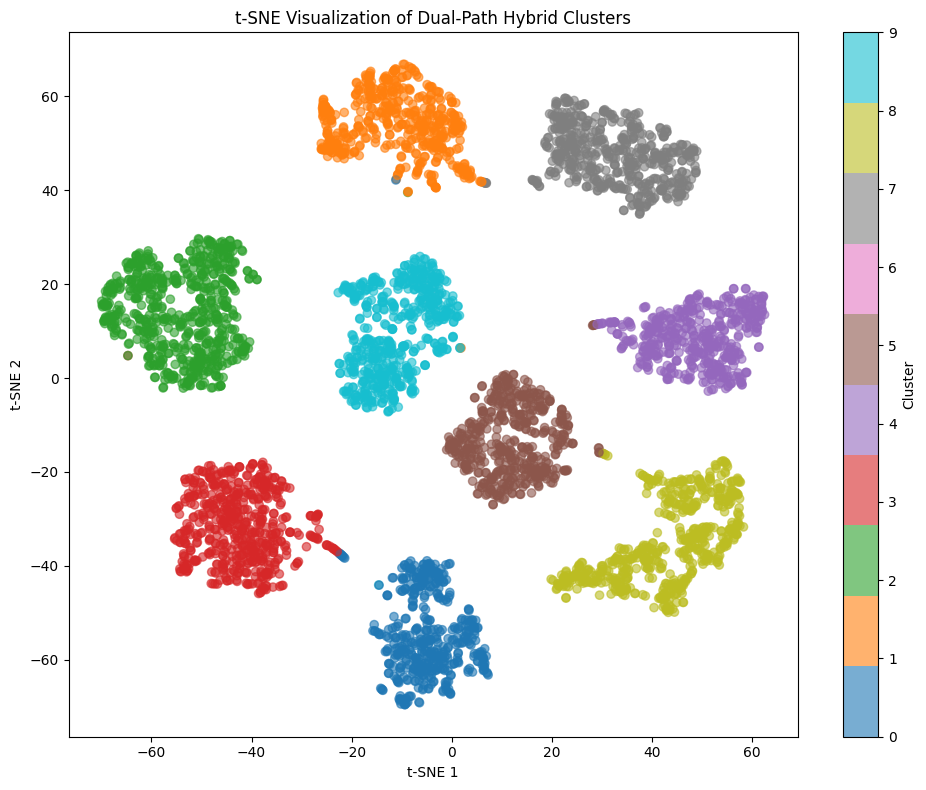

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
input_dim = 784  # 28x28 MNIST images
latent_dim = 48  # Reduced embedding dimension 
recon_dim = 32   # Reconstruction path dimension
contrast_dim = 16  # Contrastive path dimension
feature_dim = 128  # Feature extraction dimension
num_clusters = 10
batch_size = 256
epochs = 40
lr = 0.001
temperature = 0.5  # Temperature for contrastive learning
alpha = 0.5  # Weight for contrastive loss
beta = 0.1   # Weight for cluster separation loss
gamma = 0.05  # Weight for cluster assignment entropy

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the Hybrid Dual-Path Network
class DTB(nn.Module):
    def __init__(self, input_dim, feature_dim, recon_dim, contrast_dim, num_clusters):
        super().__init__()
        # Shared feature extraction
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU(),
        )
        
        # Reconstruction path
        self.recon_encoder = nn.Sequential(
            nn.Linear(feature_dim, recon_dim),
            nn.BatchNorm1d(recon_dim),
            nn.Tanh(),
        )
        
        # Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(recon_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, input_dim),
            nn.Tanh()
        )
        
        # Contrastive path
        self.contrast_encoder = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.BatchNorm1d(feature_dim // 2),
            nn.ReLU(),
            nn.Linear(feature_dim // 2, contrast_dim),
            nn.BatchNorm1d(contrast_dim),
        )
        
        # Feature importance weighting
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, 64),
            nn.ReLU(),
            nn.Linear(64, feature_dim),
            nn.Sigmoid()
        )
        
        # Clustering layer
        self.cluster_centers = nn.Parameter(torch.zeros(num_clusters, recon_dim + contrast_dim))
        
        # Initialize with reasonable values to prevent mode collapse
        nn.init.xavier_uniform_(self.cluster_centers)
        
    def encode_contrast(self, x):
        features = self.feature_extractor(x)
        weights = self.attention(features)
        weighted_features = features * weights
        return self.contrast_encoder(weighted_features)
        
    def encode_recon(self, x):
        features = self.feature_extractor(x)
        weights = self.attention(features)
        weighted_features = features * weights
        return self.recon_encoder(weighted_features)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        weights = self.attention(features)
        weighted_features = features * weights
        
        # Get both types of embeddings
        z_recon = self.recon_encoder(weighted_features)
        z_contrast = self.contrast_encoder(weighted_features)
        
        # Reconstruction
        recon = self.decoder(z_recon)
        
        # Combined embedding for clustering
        z_combined = torch.cat([z_recon, z_contrast], dim=1)
        
        # Compute soft cluster assignments using Student's t-distribution
        dist = torch.sum((z_combined.unsqueeze(1) - self.cluster_centers)**2, dim=2)
        q = 1.0 / (1.0 + dist / 1.0)
        q = q**2  # Sharpen the distribution
        q = q / q.sum(dim=1, keepdim=True)  # Normalize
        
        return z_recon, z_contrast, z_combined, recon, q

# Custom loss function for contrastive learning
def contrastive_loss(features, temperature=0.5):
    batch_size = features.size(0)
    features = F.normalize(features, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.mm(features, features.T) / temperature
    
    # Exclude the main diagonal from consideration
    mask = torch.eye(batch_size, device=features.device)
    
    # Compute positive and negative pairs - assume consecutive pairs are similar
    # This is a simplification; in practice you'd use data augmentation
    pos_mask = torch.zeros_like(mask)
    for i in range(0, batch_size - 1, 2):
        pos_mask[i, i+1] = 1
        pos_mask[i+1, i] = 1
    
    # Remove self-similarity
    sim_matrix = sim_matrix * (1 - mask)
    
    # Count positive pairs
    num_positives = pos_mask.sum(dim=1)
    
    # For numerical stability
    logits_max, _ = torch.max(sim_matrix, dim=1, keepdim=True)
    logits = sim_matrix - logits_max.detach()
    
    # Compute log probability
    exp_logits = torch.exp(logits)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True))
    
    # Calculate contrastive loss
    mean_log_prob_pos = (pos_mask * log_prob).sum(dim=1) / (num_positives + 1e-6)
    loss = -mean_log_prob_pos.mean()
    
    return loss

# Initialize model and optimizer
model = DTB(input_dim, feature_dim, recon_dim, contrast_dim, num_clusters).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Generate initial cluster assignments using KMeans
def initialize_cluster_centers(model, data_loader):
    print("Initializing cluster centers with KMeans...")
    model.eval()
    embeddings = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, _, z_combined, _, _ = model(x)
            embeddings.append(z_combined.cpu())
    embeddings = torch.cat(embeddings).numpy()
    
    kmeans = KMeans(n_clusters=num_clusters, n_init=20, random_state=42)
    kmeans.fit(embeddings)
    
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

# Target distribution for refining cluster assignments
def target_distribution(q):
    weight = q**2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()

# Training loop with progressive objectives
print("Starting training...")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    recon_losses = 0
    contrast_losses = 0
    cluster_losses = 0
    
    # Initialize cluster centers after 5 epochs
    if epoch == 5:
        model.cluster_centers.data = initialize_cluster_centers(model, train_loader)
    
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        
        # Forward pass
        z_recon, z_contrast, z_combined, recon, q = model(x)
        
        # Reconstruction loss
        recon_loss = F.mse_loss(recon, x)
        
        # Contrastive loss
        c_loss = contrastive_loss(z_contrast, temperature)
        
        # Clustering loss (KL divergence)
        if epoch >= 5:
            p = target_distribution(q.detach())
            kl_loss = F.kl_div(q.log(), p, reduction='batchmean')
            
            # Entropy regularization to prevent cluster collapse
            entropy = -torch.mean(torch.sum(q * torch.log(q + 1e-8), dim=1))
            
            # Cluster separation - push centers away from each other
            center_dists = torch.cdist(model.cluster_centers, model.cluster_centers)
            mask = 1 - torch.eye(num_clusters, device=device)
            separation_loss = -torch.min(center_dists * mask + 1e6 * (1 - mask))
            
            cluster_loss = kl_loss - gamma * entropy + beta * separation_loss
        else:
            cluster_loss = torch.tensor(0.0).to(device)
        
        # Combined loss with progressive weighting
        if epoch < 5:
            loss = recon_loss  # Phase 1: Only reconstruction
        elif epoch < 15:
            loss = recon_loss + alpha * c_loss  # Phase 2: Add contrastive
        else:
            loss = recon_loss + alpha * c_loss + cluster_loss  # Phase 3: Full objective
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        recon_losses += recon_loss.item()
        contrast_losses += c_loss.item()
        if epoch >= 5:
            cluster_losses += cluster_loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {total_loss/len(train_loader):.4f}, "
          f"Recon: {recon_losses/len(train_loader):.4f}, "
          f"Contrast: {contrast_losses/len(train_loader):.4f}, "
          f"Cluster: {cluster_losses/len(train_loader):.4f}")

# Final clustering evaluation
print("\nGenerating Clusters...")
final_embeddings = []
pred_labels = []
with torch.no_grad():
    model.eval()
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        _, _, z_combined, _, q = model(x)
        final_embeddings.append(z_combined.cpu())
        pred_labels.append(q.argmax(dim=1).cpu())
        
final_embeddings = torch.cat(final_embeddings).numpy()
pred_labels = torch.cat(pred_labels).numpy()

# Check number of clusters before evaluation
n_clusters_found = len(np.unique(pred_labels))
print(f"Number of clusters found: {n_clusters_found}")

# Clustering metrics
if n_clusters_found >= 2:
    print("\nEvaluation Metrics:")
    print(f"Silhouette Score: {silhouette_score(final_embeddings, pred_labels):.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin_score(final_embeddings, pred_labels):.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz_score(final_embeddings, pred_labels):.4f}")
else:
    print("Cannot compute metrics: insufficient number of clusters found.")

# t-SNE Visualization
print("\nGenerating t-SNE Visualization...")
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(final_embeddings[:5000])

plt.figure(figsize=(10, 8))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=pred_labels[:5000], 
                cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Dual-Path Hybrid Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()
